# **Task 1 | Mask Recognition: Classify people wearing masks**

___
___

## **1. INITIALIZATION**

### *1.1 IMPORTS*

In [2]:
from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from xml.dom import minidom

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random as rd
import time

from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import torch
import torch.nn as nn

In [3]:
# To fill the `requirement.txt` file we use the following line of code:
import session_info
session_info.show()

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


### *1.2. DATA LOADING*

In [5]:
root_dir = "data/FaceMaskDetection/"
anno_dir = root_dir + "annotations/"
imgs_dir = root_dir + "images/"

In [6]:
def get_annotations(anno_dir):

    """

    arg:
    - anno_dir (str):   the directory with the .xml annotations files
    
    out:
    - df (dataframe):   a dataframe matching an image id and a bounding box id to the size of
                        the image, the position of the bounding box and its annotation:
                        "without mask" or "mask_weared_incorrect" => 0 | "with mask" => 1  
    
    """

    files = os.listdir(anno_dir)
    files.sort()
    
    # if the dataframe doesn't exist been created yet
    if "annotations.csv" not in files:

        data = []
        mask_label = {"without_mask": 0, "mask_weared_incorrect": 1, "with_mask": 1}

        for file in files:
        
            ann = minidom.parse(anno_dir+file)
            img_id = int(ann.getElementsByTagName("filename")[0].firstChild.data[12:-4])
            img_height = int(ann.getElementsByTagName("height")[0].firstChild.data)
            img_width = int(ann.getElementsByTagName("width")[0].firstChild.data)
        
            for i,object in enumerate(ann.getElementsByTagName("object")):

                box_id = i
                label = mask_label[object.getElementsByTagName("name")[0].firstChild.data]
                xmin = object.getElementsByTagName("xmin")[0].firstChild.data
                xmax = object.getElementsByTagName("xmax")[0].firstChild.data
                ymin = object.getElementsByTagName("ymin")[0].firstChild.data
                ymax = object.getElementsByTagName("ymax")[0].firstChild.data

                data.append((img_id, img_height, img_width, box_id, label, xmin, xmax, ymin, ymax))
        
        columns = ["img_id", "img_height", "img_width", "box_id", "label", "xmin", "xmax", "ymin", "ymax"]
        pd.DataFrame(data=data, columns=columns, index=None).to_csv(anno_dir+"annotations.csv", index=None)
        
    return pd.read_csv(anno_dir+"/annotations.csv", index_col=False)

In [7]:
annotations = get_annotations(anno_dir)
display(annotations)

,img_id,img_height,img_width,box_id,label,xmin,xmax,ymin,ymax,train
0,0,366,512,0,0,79,109,105,142,True
1,0,366,512,1,1,185,226,100,144,True
2,0,366,512,2,0,325,360,90,141,True
3,1,156,400,0,1,321,354,34,69,True
4,1,156,400,1,1,224,261,38,73,True
...,...,...,...,...,...,...,...,...,...,...
4067,98,267,400,2,1,263,287,62,85,True
4068,98,267,400,3,1,344,377,80,106,True
4069,99,267,400,0,1,181,273,54,162,True
4070,99,267,400,1,1,99,176,87,165,True


In [8]:
class FaceMaskDataset(Dataset):

    def __init__(self, annotations, imgs_dir):
        self.annotations = annotations
        self.img_dir = imgs_dir
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img = plt.imread(self.img_dir+"maksssksksss{}.png".format(int(self.annotations.iloc[idx]["img_id"])))[:,:,:3]
        xmin = self.annotations.iloc[idx]["xmin"]
        xmax = self.annotations.iloc[idx]["xmax"]
        ymin = self.annotations.iloc[idx]["ymin"]
        ymax = self.annotations.iloc[idx]["ymax"]
        img = transforms.Resize((64,64))(torch.Tensor(img[ymin:ymax,xmin:xmax]).permute(2,0,1))
        label = torch.Tensor([int(self.annotations.iloc[idx]["label"])])
        return img, label

90% of the whole dataset is dedicated to training and the 20% left is used as a test dataset.

To ensure that we keep the same elements within the two datasets, even after restarting the notebook, we add add a train column to the annotation_dataframe.

In [9]:
if "train" not in annotations:

    train_size = int(0.90*len(annotations)) # len(annotations) == len(FMD)
    train_ids = rd.sample(range(len(annotations)), train_size)
    annotations["train"] = [i in train_ids for i in range(len(annotations))]
    annotations.to_csv(anno_dir+"annotations.csv", index=None)

train_dataset = FaceMaskDataset(annotations[annotations["train"]], imgs_dir)
test_dataset = FaceMaskDataset(annotations[annotations["train"] == False], imgs_dir)

batch_size = 128

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

___

## **2. THE MODELS**

### *2.1. DEFINING THE MODELS*

In [10]:
modelRSN18 = models.resnet18(pretrained=True)
for param in modelRSN18.parameters():
    param.requires_grad = False
modelRSN18.fc = nn.Sequential(
    nn.Linear(512,128),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid())

modelRSN18.to(device)
modelRSN18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
modelRSN50 = models.resnet50(pretrained=True)
for param in modelRSN50.parameters():
    param.requires_grad = False
modelRSN50.fc = nn.Sequential(
    nn.Linear(2048,128),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid())

modelRSN50.to(device)
modelRSN50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# modelVGG19 = models.vgg19(pretrained=True)
# for param in modelVGG19.parameters():
#     param.requires_grad = False
# modelVGG19.fc = nn.Sequential(
    # nn.Linear(2048,128),
    # nn.ReLU(),
    # nn.Linear(128,1),
    # nn.Sigmoid())

# modelVGG19.to(device)
# modelVGG19.eval()

### *2.2. TRAINING*

In [23]:
def train_model(model, criterion, optimizer, nb_epochs, epoch_print_frequence):

    s = time.time()

    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    for epoch in range(nb_epochs):

        running_loss_train, running_loss_test, running_acc_train, running_acc_test = 0,0,0,0

        for train in [True, False]:

            if train:
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = test_dataloader
                model.eval()

            for inputs,labels in dataloader:

                inputs = inputs.to(device)
                labels = labels.to(device)

                if train:
                    optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if train:
                    loss.backward()
                    optimizer.step()
                    running_loss_train += loss.item()
                    running_acc_train += np.sum(labels.cpu().detach().numpy() == np.round(outputs.cpu().detach().numpy())) 
                    
                else:
                    running_loss_test += loss.item()
                    running_acc_test += np.sum(labels.cpu().detach().numpy() == np.round(outputs.cpu().detach().numpy())) 

        running_loss_train /= len(train_dataset)
        running_loss_test /= len(test_dataset)
        running_acc_train /= len(train_dataset)
        running_acc_test /= len(test_dataset)

        train_losses.append(running_loss_train)
        test_losses.append(running_loss_test)
        train_accuracies.append(running_acc_train)
        test_accuracies.append(running_acc_test)

        if epoch % epoch_print_frequence == 0 and epoch > 0:
            print("epochs {} ({} s) | train loss : {} | test loss : {} | train acc : {} | test acc : {}".format(
                epoch,
                int(time.time()-s),
                int(1000000*running_loss_train)/1000000,
                int(1000000*running_loss_test)/1000000,
                int(1000000*running_acc_train)/1000000,
                int(1000000*running_acc_test)/1000000)
            )
    
    return train_losses, test_losses, train_accuracies, test_accuracies

In [24]:
optimizerRSN18 = torch.optim.Adam(modelRSN18.parameters(), lr=1e-3)
optimizerRSN50 = torch.optim.Adam(modelRSN50.parameters(), lr=1e-3)
# optimizerVGG19 = torch.optim.Adam(modelVGG19.parameters(), lr=1e-3)

criterionRSN18 = nn.CrossEntropyLoss().cuda()
criterionRSN50 = nn.CrossEntropyLoss().cuda()
# criterionVGG19 = nn.CrossEntropyLoss().cuda()

In [25]:
nb_epochs, epoch_print_frequence = 50, 5

In [26]:
resultsRSN18 = train_model(modelRSN18, criterionRSN18, optimizerRSN18, nb_epochs, epoch_print_frequence)

In [ ]:
resultsRSN50 = train_model(modelRSN50, criterionRSN50, optimizerRSN50, nb_epochs, epoch_print_frequence)

In [ ]:
# resultsVGG19 = train_model(modelVGG19, criterionVGG19, optimizerVGG19, nb_epochs, epoch_print_frequence)

### *2.3. SAVING THE MODEL*

In [ ]:
torch.save(modelRSN18.state_dict(), "./models/MaskRecognitionRSN18.pt")

In [ ]:
torch.save(modelRSN50.state_dict(), "./models/MaskRecognitionRSN50.pt")

In [ ]:
# torch.save(modelVGG19.state_dict(), "./models/MaskRecognitionVGG19.pt")

___

## **3. TESTING THE MODELS**

### *3.1. LOADING THE MODELS*

In [ ]:
modelRSN18 = models.resnet18(pretrained=True)
for param in modelRSN18.parameters():
    param.requires_grad = False
modelRSN18.fc = nn.Sequential(
    nn.Linear(512,1),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid())

modelRSN18.to(device)
modelRSN18.load_state_dict(torch.load("./models/MaskRecognitionRSN18.pt"))
modelRSN18.eval()

In [ ]:
modelRSN50 = models.resnet50(pretrained=True)
for param in modelRSN50.parameters():
    param.requires_grad = False
modelRSN50.fc = nn.Sequential(
    nn.Linear(2048,1),
    nn.ReLU(),
    nn.Linear(128,1),
    nn.Sigmoid())

modelRSN50.to(device)
modelRSN50.load_state_dict(torch.load("./models/MaskRecognitionRSN50.pt"))
modelRSN50.eval()

In [ ]:
# modelVGG19 = models.vgg19(pretrained=True)
# for param in modelVGG19.parameters():
#     param.requires_grad = False

# modelVGG19.to(device)
# modelVGG19.load_state_dict(torch.load("./models/MaskRecognitionVGG19.pt"))
# modelVGG19.eval()

### *3.2. ACCURACIES*

In [ ]:
train_labels = np.array(annotations[annotations["train"]]["label"])
test_labels = np.array(annotations[annotations["train"] == False]["label"])

In [ ]:
train_labelsRSN18 = []
train_labelsRSN50 = []
# train_labelsVGG19 = []

test_labelsRSN18 = []
test_labelsRSN50 = []
# test_labelsVGG19 = []

for i in tqdm(range(len(annotations))):

    img = plt.imread(imgs_dir+"/maksssksksss{}.png".format(annotations.iloc[i]["img_id"]))[:,:,:3]
    xmin = annotations.iloc[i]["xmin"]
    xmax = annotations.iloc[i]["xmax"]
    ymin = annotations.iloc[i]["ymin"]
    ymax = annotations.iloc[i]["ymax"]

    label = annotations.iloc[i]["label"]

    img_tensor = transforms.Resize((64,64))(torch.Tensor(img[ymin:ymax,xmin:xmax]).permute(2,0,1))
    img_tensor = img_tensor.reshape((1,3,64,64)).to(device)

    predRSN18 = torch.round(modelRSN18(img_tensor)).item()
    predRSN50 = torch.round(modelRSN50(img_tensor)).item()
    # predVGG19 = torch.round(modelVGG19(img_tensor)).item()

    if annotations.iloc[i]["train"]:
        train_labelsRSN18.append(predRSN18)
        train_labelsRSN50.append(predRSN50)
        # train_labelsVGG19.append(predVGG19)
    else:
        test_labelsRSN18.append(predRSN18)
        test_labelsRSN50.append(predRSN50)
        # test_labelsVGG19.append(predVGG19)

train_labelsRSN18 = np.array(train_labelsRSN18)
train_labelsRSN50 = np.array(train_labelsRSN50)
# train_labelsVGG19 = np.array(train_labelsVGG19)

test_labelsRSN18 = np.array(test_labelsRSN18)
test_labelsRSN50 = np.array(test_labelsRSN50)
# test_labelsVGG19 = np.array(test_labelsVGG19)

NameError: name 'tqdm' is not defined

In [ ]:
train_cmRSN18 = confusion_matrix(train_labels, train_labelsRSN18)
train_dispRSN18 = ConfusionMatrixDisplay(confusion_matrix=train_cmRSN18)
train_dispRSN18.plot()
plt.title("ResNet18 Confusion Matrix\nOver the Train Dataset")
plt.show()

In [ ]:
test_cmRSN18 = confusion_matrix(test_labels, test_labelsRSN18)
test_dispRSN18 = ConfusionMatrixDisplay(confusion_matrix=test_cmRSN18)
test_dispRSN18.plot()
plt.title("ResNet18 Confusion Matrix\nOver the Test Dataset")
plt.show()

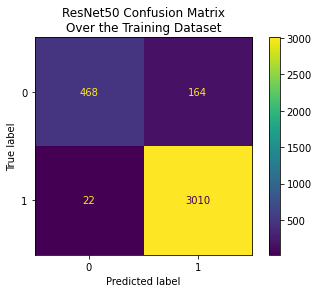

In [ ]:
train_cmRSN50 = confusion_matrix(train_labels, train_labelsRSN50)
train_dispRSN50 = ConfusionMatrixDisplay(confusion_matrix=train_cmRSN50)
train_dispRSN50.plot()
plt.title("ResNet50 Confusion Matrix\nOver the Train Dataset")
plt.show()

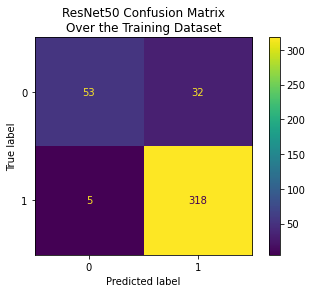

In [ ]:
test_cmRSN50 = confusion_matrix(test_labels, test_labelsRSN50)
test_dispRSN50 = ConfusionMatrixDisplay(confusion_matrix=test_cmRSN50)
test_dispRSN50.plot()
plt.title("ResNet50 Confusion Matrix\nOver the Test Dataset")
plt.show()

In [ ]:
# train_cmVGG19 = confusion_matrix(train_labels, train_labelsVGG19)
# train_dispVGG19 = ConfusionMatrixDisplay(confusion_matrix=train_cmVGG19)
# train_dispVGG19.plot()
# plt.title("VGGNet19 Confusion Matrix\nOver the Train Dataset")
# plt.show()

In [ ]:
# test_cmVGG19 = confusion_matrix(test_labels, test_labelsVGG19)
# test_dispVGG19 = ConfusionMatrixDisplay(confusion_matrix=test_cmVGG19)
# test_dispVGG19.plot()
# plt.title("VGGNet19 Confusion Matrix\nOver the Train Dataset")
# plt.show()

### *3.3. VISUALIZING PREDICTION*

In [ ]:
def show_random_results(model, nb_images):

    img_ids = rd.sample(list(annotations["img_id"]), nb_images)

    for img_id in img_ids:

        a = annotations[annotations["img_id"] == img_id]
        img = plt.imread(imgs_dir+"/maksssksksss{}.png".format(img_id))[:,:,:3]
        overlay = img.copy()
        output = img.copy()

        for i in range(len(a)):
            
            xmin = a.iloc[i]["xmin"]
            xmax = a.iloc[i]["xmax"]
            ymin = a.iloc[i]["ymin"]
            ymax = a.iloc[i]["ymax"]
            
            img_tensor = transforms.Resize((64,64))(torch.Tensor(img[ymin:ymax,xmin:xmax]).permute(2,0,1))
            img_tensor = img_tensor.reshape((1,3,64,64)).to(device)
            pred = torch.round(model(img_tensor)).item()

            if pred == 0:
                cv2.rectangle(overlay, (xmin,ymin), (xmax,ymax), (2,0,0), -1)
            
            else:
                cv2.rectangle(overlay, (xmin,ymin), (xmax,ymax), (0,1,0), -1)
            
            output = cv2.addWeighted(overlay, 0.05, output, 0.90, 0, output)
                
        plt.figure(figsize=(15,9))
        plt.imshow(output)
        plt.show()

In [ ]:
show_random_results(modelRSN50, 5)